# Imports

In [24]:
import glob

import numpy as np 
import pandas as pd

from scipy.spatial import ConvexHull

# scikit learn imports for classification functions
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Reading the dataset

From the readme for the xyz files, we know that:

Ground truth labels:
|File range|Label|
|:--|:--|
|    000 - 099: |building|
|    100 - 199: |car|
|    200 - 299: |fence|
|    300 - 399: |pole|
|    400 - 499: |tree|

In following cell: iterate through the files, and collect them in a dataframe

In [6]:
xyzPath = './scene_objects/data/*.xyz'
dataPathsList = glob.glob(xyzPath)

allPointsDF= pd.DataFrame(columns=['x','y','z', 'fileNo', 'groundLabel'])
# featureDF = pd.DataFrame(columns=['Label' , 'convHull', median] )

labelToGive = None
for path in dataPathsList:
    indx = int(path.split('\\')[-1][0:3])
    # if else to determine label
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree'       

    # using pandas to read dataset and make a dataFrame
    tempDF = pd.read_csv(path, delimiter=' ', header=None, dtype=np.float64, names=['x','y','z'])
    tempDF.loc[:,'fileNo'] = indx
    tempDF.loc[:,'groundLabel'] = labelToGive

    # merge with megaDFofPoints
    allPointsDF = pd.concat([allPointsDF, tempDF], sort=False, ignore_index=True)

allPointsDF.head()

,x,y,z,fileNo,groundLabel
0,20.070000,499.959991,17.450001,0,building
1,20.370001,499.160004,17.290001,0,building
2,18.860001,499.559998,18.129999,0,building
3,18.120001,499.709991,18.540001,0,building
4,17.360001,499.950012,19.000000,0,building


# Features engineering

normalize the feature df <br/>
[from stackoverflow we see](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame), that we can just use pandas for a standard scaling, or else, a [standard scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) can also be applied </br>

from [answer here](https://stats.stackexchange.com/questions/417339/data-standardization-vs-normalization-for-clustering-analysis), we see that standard scaler is used for k means , so we are going with that

In [7]:
def label_determiner(indx):
    labelToGive=None
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree' 
    return labelToGive


featureDF = allPointsDF.groupby('fileNo').var()
featureDF.rename(columns={'x':'varX','y':'varY','z':'varZ'}, inplace=True)
#featureDF.loc[:,'median_Z'] = allPointsDF.groupby('fileNo').z.median()
featureDF.loc[:,'mean_Z'] = allPointsDF.groupby('fileNo').z.mean()

# range of x,y,z
featureDF.loc[:,'range_X'] = allPointsDF.groupby('fileNo').x.max() - allPointsDF.groupby('fileNo').x.min()
featureDF.loc[:,'range_Y'] = allPointsDF.groupby('fileNo').y.max() - allPointsDF.groupby('fileNo').y.min()
featureDF.loc[:,'range_Z'] = allPointsDF.groupby('fileNo').z.max() - allPointsDF.groupby('fileNo').z.min()

featureDF.loc[:,'Volume'] = allPointsDF.set_index('fileNo').loc[:,'x':'z'].groupby('fileNo').apply(ConvexHull).apply(lambda x: x.volume)

# point density
featureDF.loc[:,'footprintDensity'] =  allPointsDF.groupby('fileNo').count().x / (featureDF.range_X * featureDF.range_Y)
featureDF.loc[:,'volumeDensity'] =  allPointsDF.groupby('fileNo').count().x / featureDF.Volume

# delete varX, varY, varZ
featureDF = featureDF.drop(columns = ['varX', 'varY', 'varZ','range_X','range_Y'], axis = 1)

featureDF.loc[:,'label'] = featureDF.reset_index().fileNo.apply(label_determiner)
noLabelFeatureDF = featureDF.iloc[:,:-1].copy() # delete label column

# standardize DF
standardFeatureDF = (noLabelFeatureDF - noLabelFeatureDF.mean() ) / noLabelFeatureDF.std()
standardFeatureDF = standardFeatureDF.join(other=featureDF.label , on='fileNo') # join labels to the DF

# normalize df using min max scaling
minMaxFeatureDF = (noLabelFeatureDF- noLabelFeatureDF.min()) / (noLabelFeatureDF.max() - noLabelFeatureDF.min())
minMaxFeatureDF = minMaxFeatureDF.join(other=featureDF.label , on='fileNo') # join labels to the DF

minMaxFeatureDF.head()

,mean_Z,range_Z,Volume,footprintDensity,volumeDensity,label
fileNo,,,,,,
0,0.716721,0.199121,0.004124,0.382691,0.126469,building
1,0.229411,0.136703,0.005448,0.329856,0.109521,building
2,0.486472,0.307692,0.049745,0.336488,0.049716,building
3,0.526394,0.289231,0.052889,0.297612,0.054039,building
4,0.249514,0.207473,0.043882,0.237640,0.078642,building


### Correlation matrix
Summarize data with a table that showscorrelation coefficients between variables

In [25]:
minMaxFeatureDF.corr()

,mean_Z,range_Z,Volume,footprintDensity,volumeDensity
mean_Z,1.000000,0.682717,0.041521,0.251874,-0.318701
range_Z,0.682717,1.000000,0.118549,0.314815,-0.576959
Volume,0.041521,0.118549,1.000000,0.014749,-0.210111
footprintDensity,0.251874,0.314815,0.014749,1.000000,0.165924
volumeDensity,-0.318701,-0.576959,-0.210111,0.165924,1.000000


### Plotting to see resemblamces and clusters

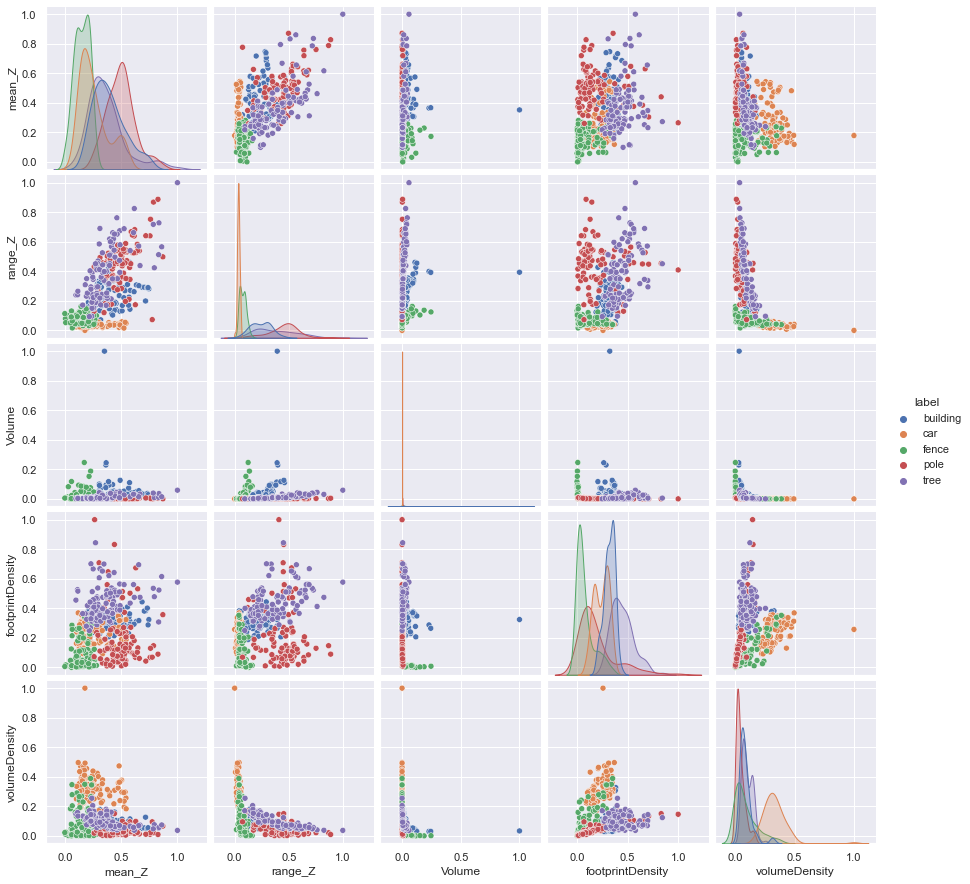

In [70]:
sns.pairplot(data=minMaxFeatureDF, hue="label")

# Classification
## Split the dataset

In [3]:
def testTrainSplitter(DataFrame, testSize=0.3, randomState=45):
    """
    Summary: takes a dataframe in the format of the one defined in section making features, and returns test set train set X,y.
    ===================
    Arguments:
        DataFrame (pd.DataFrame):
        testSize (float):
        randomState (int):
    Returns:
    """
    X = DataFrame.drop('label', axis=1)
    y = DataFrame.loc[:,'label']
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=testSize, random_state=randomState , shuffle=True)
    return (X_train, X_test, y_train, y_test)


In [8]:
# split dataset
minMax_X_train, minMax_X_test, minMax_y_train, minMax_y_test = testTrainSplitter(minMaxFeatureDF)

## learning curve

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# https://www.projectpro.io/recipes/plot-learning-curve-in-python

def learningCurve(estimator,X,y):
    """
    Determines cross-validated training and test scores for different training set sizes.
    Parameters:
        estimator: An object of that type which is cloned for each validation.
        X: array-like of shape (n_samples, n_features). Training vector, where n_samples is the number of samples and n_features is the number of features.
        y: array-like of shape (n_samples,) or (n_samples, n_outputs).Target relative to X for classification or regression; None for unsupervised learning.
    Return:
        No return. Just plot the curve.
    """
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

## SVM

In [21]:
svmClassifier = SVC(decision_function_shape='ovo', kernel='linear') # function from sklearn
svmClassifier.fit(minMax_X_train, minMax_y_train)

svmPredList = svmClassifier.predict(minMax_X_test)

#accuracyEvaluation(svmPredList , minMax_y_test)

svmAccuracy = accuracy_score(minMax_y_test, svmPredList)
svmAccuracy

0.8333333333333334

In [22]:
confusion_matrix(minMax_y_test, svmPredList)

array([[24,  2,  0,  1,  1],
       [ 0, 26,  1,  0,  0],
       [ 0,  6, 25,  0,  0],
       [ 2,  0,  0, 26,  3],
       [ 9,  0,  0,  0, 24]], dtype=int64)

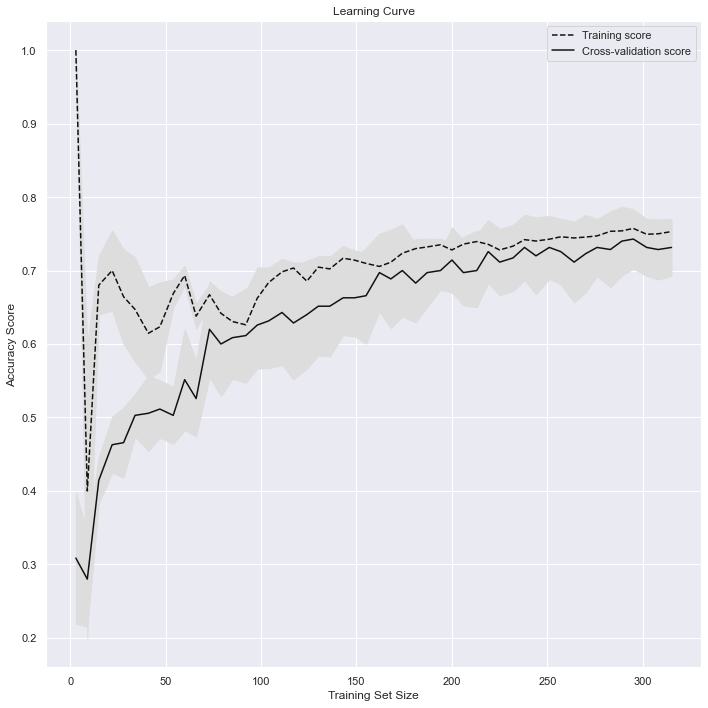

In [ ]:
learningCurve(SVC(),minMax_X_train, minMax_y_train)

## Random Forest

In [19]:
rfClassifier = RandomForestClassifier(n_estimators = 50, max_depth=2, random_state=0)
rfClassifier.fit(minMax_X_train, minMax_y_train)

rfPredList = rfClassifier.predict(minMax_X_test)
#accuracyEvaluation( rfPredList , minMax_y_test)

rfAccuracy = accuracy_score(minMax_y_test, rfPredList)
rfAccuracy

0.7866666666666666

In [23]:
confusion_matrix(minMax_y_test, rfPredList)

array([[23,  1,  3,  1,  0],
       [ 0, 25,  2,  0,  0],
       [ 0,  2, 29,  0,  0],
       [ 0,  0,  1, 26,  4],
       [18,  0,  0,  0, 15]], dtype=int64)

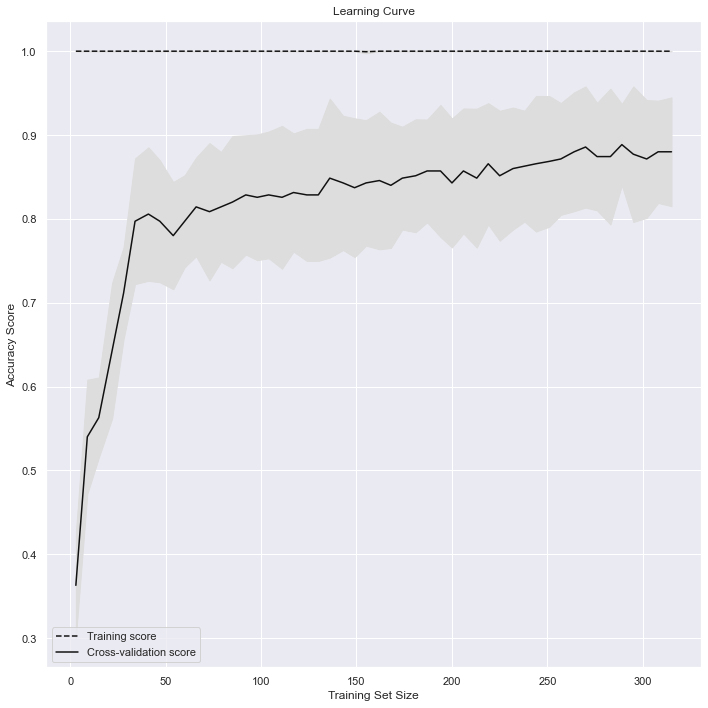

In [ ]:
learningCurve(RandomForestClassifier(), minMax_X_train, minMax_y_train)